In [1]:
# !pip install category-encoders
# !pip install lightgbm

In [2]:
## main
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


## secondary
from datasist.structdata import detect_outliers
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## sklearn -- preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline,FeatureUnion
from sklearn_features.transformers import DataFrameSelector
from sklearn.compose import ColumnTransformer
from category_encoders import BinaryEncoder
## sklearn -- models
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB
import lightgbm
import joblib
## sklearn -- metrics
from sklearn.metrics import r2_score
## deployment
import streamlit


#### `1. EDA`

In [3]:
## using pandas
TRAIN_DATASET_PATH = os.path.join(os.getcwd(), 'Engineering_graduate_salary.csv')
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,ID,Gender,DOB,10percentage,10board,12graduation,12percentage,12board,CollegeID,CollegeTier,...,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience,Salary
0,604399,f,1990-10-22,87.80,cbse,2009,84.00,cbse,6920,1,...,-1,-1,-1,-1,-0.1590,0.3789,1.2396,0.14590,0.2889,445000
1,988334,m,1990-05-15,57.00,cbse,2010,64.50,cbse,6624,2,...,-1,-1,-1,-1,1.1336,0.0459,1.2396,0.52620,-0.2859,110000
2,301647,m,1989-08-21,77.33,"maharashtra state board,pune",2007,85.17,amravati divisional board,9084,2,...,-1,-1,260,-1,0.5100,-0.1232,1.5428,-0.29020,-0.2875,255000
3,582313,m,1991-05-04,84.30,cbse,2009,86.00,cbse,8195,1,...,-1,-1,-1,-1,-0.4463,0.2124,0.3174,0.27270,0.4805,420000
4,339001,f,1990-10-30,82.00,cbse,2008,75.00,cbse,4889,2,...,-1,-1,-1,-1,-1.4992,-0.7473,-1.0697,0.06223,0.1864,200000


In [4]:
## check info and stats
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2998 entries, 0 to 2997
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     2998 non-null   int64  
 1   Gender                 2998 non-null   object 
 2   DOB                    2998 non-null   object 
 3   10percentage           2998 non-null   float64
 4   10board                2998 non-null   object 
 5   12graduation           2998 non-null   int64  
 6   12percentage           2998 non-null   float64
 7   12board                2998 non-null   object 
 8   CollegeID              2998 non-null   int64  
 9   CollegeTier            2998 non-null   int64  
 10  Degree                 2998 non-null   object 
 11  Specialization         2998 non-null   object 
 12  collegeGPA             2998 non-null   float64
 13  CollegeCityID          2998 non-null   int64  
 14  CollegeCityTier        2998 non-null   int64  
 15  Coll

In [5]:
##n stats
df.describe()

,ID,10percentage,12graduation,12percentage,CollegeID,CollegeTier,collegeGPA,CollegeCityID,CollegeCityTier,GraduationYear,...,MechanicalEngg,ElectricalEngg,TelecomEngg,CivilEngg,conscientiousness,agreeableness,extraversion,nueroticism,openess_to_experience,Salary
count,2.998000e+03,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,...,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2998.000000,2.998000e+03
mean,6.648926e+05,77.666264,2008.080720,74.341061,5210.210807,1.924616,71.509857,5210.210807,0.296197,2011.939960,...,24.138759,16.267845,31.068379,1.946965,-0.038714,0.126217,-0.008662,-0.145965,-0.141111,3.051748e+05
std,3.648951e+05,10.002785,1.631814,11.120299,4776.609877,0.264053,8.122462,4776.609877,0.456655,36.780582,...,99.785138,86.054739,103.552963,32.241501,1.024974,0.955831,0.962695,1.012901,1.007134,2.123312e+05
min,1.124400e+04,43.000000,1998.000000,40.000000,2.000000,1.000000,6.630000,2.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-3.893300,-5.781600,-4.600900,-2.643000,-7.375700,3.500000e+04
25%,3.334648e+05,71.140000,2007.000000,66.000000,526.250000,2.000000,66.530000,526.250000,0.000000,2012.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-0.649100,-0.435300,-0.604800,-0.868200,-0.669200,1.800000e+05
50%,6.396945e+05,78.965000,2008.000000,74.000000,4027.500000,2.000000,71.800000,4027.500000,0.000000,2013.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.046400,0.212400,0.091400,-0.172700,-0.094300,3.000000e+05
75%,9.951770e+05,85.600000,2009.000000,82.600000,8822.250000,2.000000,76.300000,8822.250000,1.000000,2014.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,0.702700,0.812800,0.672000,0.526200,0.502400,3.700000e+05
max,1.297877e+06,97.760000,2012.000000,98.700000,18409.000000,2.000000,99.930000,18409.000000,1.000000,2017.000000,...,623.000000,660.000000,548.000000,500.000000,1.995300,1.904800,2.161700,3.352500,1.630200,4.000000e+06


In [6]:
## size
print('The shape of Training Dataset is \t', df.shape)

The shape of Training Dataset is 	 (2998, 34)


In [7]:
## check nulls
df.isna().sum(axis=0).sort_values(ascending=False) / df.shape[0]

ID                       0.0
ElectricalEngg           0.0
Quant                    0.0
Domain                   0.0
ComputerProgramming      0.0
ElectronicsAndSemicon    0.0
ComputerScience          0.0
MechanicalEngg           0.0
TelecomEngg              0.0
Gender                   0.0
CivilEngg                0.0
conscientiousness        0.0
agreeableness            0.0
extraversion             0.0
nueroticism              0.0
openess_to_experience    0.0
Logical                  0.0
English                  0.0
GraduationYear           0.0
CollegeState             0.0
CollegeCityTier          0.0
CollegeCityID            0.0
collegeGPA               0.0
Specialization           0.0
Degree                   0.0
CollegeTier              0.0
CollegeID                0.0
12board                  0.0
12percentage             0.0
12graduation             0.0
10board                  0.0
10percentage             0.0
DOB                      0.0
Salary                   0.0
dtype: float64

In [8]:
## using  missingno
# missingno.matrix(df)
# plt.show()

In [9]:
## check duplicates
df.duplicated().sum(axis=0)

0

#### `1.1 Data Cleaning`

In [10]:
#rename columns
df.rename(columns = {'10percentage': 'percentage_10', '10board': 'board_10','12graduation': 'graduation_12'}, inplace = True)
df.rename(columns = {'12board':'board_12', '12percentage': 'percentage_12'}, inplace = True)



In [11]:

def edit_board_12(current_column):
    idx1 = df[df[current_column]=='0'].index
    df.loc[idx1, current_column] = df[current_column].mode()

    idx2 = df[(df[current_column]=='u p board')|(df[current_column]=='bright way college, (up board)')|(df[current_column]=='u p')
            |(df[current_column]=='up bord')|(df[current_column]=='upboard')|(df[current_column]=='up')|(df[current_column]=='up bourd')
            |(df[current_column]=='up baord')].index
    df.loc[idx2, current_column] = 'up board'

    idx3 = df[ (df[current_column]=='board of intermediate education')|(df[current_column]=='intermediate')
            |(df[current_column]=='board of intermeadiate education')|(df[current_column]=='intermidiate')
            |(df[current_column]=='baord of intermediate education')|(df[current_column]=='board of intermediate')].index
    df.loc[idx3, current_column] = 'intermediate board'

    idx4 = df[ (df[current_column]=='hisher seconadry examination(state board)')|(df[current_column]=='kerala state board')
            |(df[current_column]=='kerala state hse board')|(df[current_column]=='board of higher secondary examination, kerala')
            |(df[current_column]=='hse')].index
    df.loc[idx4, current_column] = 'kerala board'

    idx5 = df[ (df[current_column]=='p u board, karnataka')|(df[current_column]=='karnataka pre university board')
            |(df[current_column]=='pu')|(df[current_column]=='pu board ,karnataka')|(df[current_column]=='pu board karnataka')
            |(df[current_column]=='epartment of pre-university education')|(df[current_column]=='puboard')
            |(df[current_column]=='pre university board of karnataka')|(df[current_column]=='department of pre-university education')
            |(df[current_column]=='pre-university board')|(df[current_column]=='pre university board, karnataka')
            |(df[current_column]=='dept of pre-university education')|(df[current_column]=='karnataka pre-university board')
            |(df[current_column]=='dpue')| (df[current_column]=='pre university board')|(df[current_column]=='pre-university')
            |(df[current_column]=='pre-university')|(df[current_column]=='pub')|(df[current_column]=='pue')].index
    df.loc[idx5, current_column] = 'pu board'

    idx6 = df[ (df[current_column]=='state board - west bengal council of higher secondary education : wbchse')
            |(df[current_column]=='west bengal state council of technical education')
            |(df[current_column]=='west bengal council of higher secondary education')].index
    df.loc[idx6, current_column] = 'wbchse'

    idx7 = df[ (df[current_column]=='karnataka education board')|(df[current_column]=='karnataka state')
            |(df[current_column]=='karnataka state board')|(df[current_column]=='karnataka pu board')
            |(df[current_column]=='karnataka pre unversity board')].index
    df.loc[idx7, current_column] = 'karnataka board'

    idx8 = df[ (df[current_column]=='board of intermediate education,ap')|(df[current_column]=='board fo intermediate education, ap')
            |(df[current_column]=='state  board of intermediate education, andhra pradesh')|(df[current_column]=='ap')
            |(df[current_column]=='board of intermediate ap')|(df[current_column]=='board of intermediate education, andhra pradesh')
            |(df[current_column]=='board of intmediate education ap')|(df[current_column]=='andhra board')
            |(df[current_column]=='andhra pradesh state board')|(df[current_column]=='board of intermediate education, ap')
            |(df[current_column]=='ap intermediate board')|(df[current_column]=='ap board for intermediate education') ].index
    df.loc[idx8, current_column] = 'ap board'

    idx9 = df[ (df[current_column]=='directorate of technical education,banglore')
            |(df[current_column]=='department of technical education, bangalore')].index
    df.loc[idx9, current_column] = 'banglore board'
    
    idx10 = df[ (df[current_column]=='maharashtra state board')|(df[current_column]=='maharashtra satate board')
            |(df[current_column]=='maharashtra')|(df[current_column]=='maharashtra state(latur board)') ].index
    df.loc[idx10, current_column] = 'maharashtra board'

    idx11 = df[ (df[current_column]=='state')|(df[current_column]=='stateboard')].index
    df.loc[idx11, current_column] = 'state board'

    idx12 = df[ (df[current_column]=='higher secondary state certificate')
            |(df[current_column]=='certificate for higher secondary education (chse)orissa')
            |(df[current_column]=='board of secondary school of education')].index
    df.loc[idx12, current_column] = 'hsc'

    idx13 = df[ (df[current_column]=='rajasthan board of secondary education')
            |(df[current_column]=='board of secondary education, rajasthan')|(df[current_column]=='rajasthan board ajmer')].index
    df.loc[idx13, current_column] = 'rajasthan board'

    idx14 = df[ (df[current_column]=='mpboard')|(df[current_column]=='mp')|(df[current_column]=='mpbse')
            |(df[current_column]=='madhya pradesh board')|(df[current_column]=='madhya pradesh open school')].index
    df.loc[idx14, current_column] = 'mp board'

    idx15 = df[ (df[current_column]=='bseb')].index
    df.loc[idx15, current_column] = 'pseb'

    idx16 = df[ (df[current_column]=='mp')|(df[current_column]=='mpboard')|(df[current_column]=='state boardmp board ')].index
    df.loc[idx16, current_column] = 'mp board'

    r = df[current_column].value_counts()
    df.loc[df[current_column].isin(r[r<5].index), current_column] = df[current_column].mode()

edit_board_12('board_12')

In [12]:
#change datatype for DOB column to datetime
df.DOB.value_counts()
df['DOB'] = pd.to_datetime(df['DOB'], infer_datetime_format=True)

In [13]:
## edit Specialization column 
def edit_Specialization(current_column):
    
    idx1 = df[ (df[current_column]=='mechanical and automation')|(df[current_column]=='mechanical & production engineering')
              |(df[current_column]=='automobile/automotive engineering')].index
    df.loc[idx1, current_column] = 'mechanical engineering'
        
    idx2 = df[ (df[current_column]=='instrumentation and control engineering')|(df[current_column]=='electronics and communication engineering')
              |(df[current_column]=='applied electronics and instrumentation')|(df[current_column]=='electronics and computer engineering')
              |(df[current_column]=='electronics & instrumentation eng')|(df[current_column]=='electronics')
              |(df[current_column]=='electronics and instrumentation engineering')].index
    df.loc[idx2, current_column] = 'electronics engineering'
    
    idx3 = df[ (df[current_column]=='information & communication technology')|(df[current_column]=='celectronics & telecommunications')].index
    df.loc[idx3, current_column] = 'telecommunication engineering'
        
    idx4 = df[ (df[current_column]=='computer application')|(df[current_column]=='computer networking')
              |(df[current_column]=='information technology')|(df[current_column]=='computer science & engineering')
              |(df[current_column]=='computer science and technology')|(df[current_column]=='computer and communication engineering')
              |(df[current_column]=='information science engineering')|(df[current_column]=='information science')].index
    df.loc[idx4, current_column] = 'computer engineering'

       
    idx5 = df[ (df[current_column]=='control and instrumentation engineering')|(df[current_column]=='electronics and electrical engineering')
              |(df[current_column]=='electrical and power engineering')].index
    df.loc[idx5, current_column] = 'electrical engineering'
    
    r = df[current_column].value_counts()
    df.loc[df[current_column].isin(r[r<13].index), current_column] = 'other'   
## apply
edit_Specialization('Specialization')


In [14]:
def edit_board_10(current_column):
    idx1 = df[ (df[current_column]=='karnataka')|(df[current_column]=='karnataka secondary school of examination')
              |(df[current_column]=='karnataka secondary education board')|(df[current_column]=='karnataka education board')
              |(df[current_column]=='karnataka state education examination board')|(df[current_column]=='karnataka state board')
              |(df[current_column]=='karnataka board of higher education')|(df[current_column]=='karnataka secondary education examination board')
              |(df[current_column]=='karnataka education board (keeb)')|(df[current_column]=='karnataka secondary education')
              |(df[current_column]=='karnataka state secondary education board')].index
    df.loc[idx1, current_column] = 'karnataka board'

    idx2 = df[ (df[current_column]=='matric')].index
    df.loc[idx2, current_column] = 'metric'

    idx3 = df[ (df[current_column]=='maharashtra state board')|(df[current_column]=='maharashtra sate board')
              |(df[current_column]=='maharashtra state board,pune')|(df[current_column]=='maharastra board')
              |(df[current_column]=='maharashtra satate board')|(df[current_column]=='ssc maharashtra board')
              |(df[current_column]=='maharashtra state board of secondary and higher secondary education')
              |(df[current_column]=='maharashtra state board for ssc')].index
    df.loc[idx3, current_column] = 'maharashtra board'

    idx4 = df[ (df[current_column]=='state')|(df[current_column]=='stateboard')].index
    df.loc[idx4, current_column] = 'state board'   

    idx5 = df[ (df[current_column]=='up bourd')|(df[current_column]=='upboard')|(df[current_column]=='up')
              |(df[current_column]=='u p board')|(df[current_column]=='bright way college, (up board)')
              |(df[current_column]=='u p')|(df[current_column]=='up bord')|(df[current_column]=='up baord')
              |(df[current_column]=='up board , allahabad')|(df[current_column]=='up(allahabad)')
              |(df[current_column]=='up board,allahabad')].index
    df.loc[idx5, current_column] = 'up board'

    idx6 = df[ (df[current_column]=='mp')|(df[current_column]=='mpboard')|(df[current_column]=='state boardmp board ')
              |(df[current_column]=='mpbse')].index
    df.loc[idx6, current_column] = 'mp board'

    idx7 = df[df[current_column]=='0'].index
    df.loc[idx7, current_column] = df[current_column].mode()

    idx8 = df[ (df[current_column]=='rajasthan board of secondary education')|(df[current_column]=='rajasthan board ajmer')
              |(df[current_column]=='board of secondary education, rajasthan')|(df[current_column]=='secondary board of rajasthan')].index
    df.loc[idx8, current_column] = 'rajasthan board'

    idx9 = df[ (df[current_column]=='state board - west bengal board of secondary education : wbbse')|(df[current_column]=='wbbse')
              |(df[current_column]=='west bengal board of secondary education')].index
    df.loc[idx9, current_column] = 'wbbse board'

    idx10 = df[ (df[current_column]=='board of secondary education - andhra pradesh')
               |(df[current_column]=='board of secondary education,andhara pradesh')
              |(df[current_column]=='board of secondary education, andhra pradesh')
              |(df[current_column]=='board of secondary education,andhra pradesh')
              |(df[current_column]=='board of ssc education andhra pradesh')
              |(df[current_column]=='state board of secondary education, andhra pradesh')].index
    df.loc[idx10, current_column] = 'andhra pradesh board'


    idx11 = df[ (df[current_column]=='uttar pradesh')].index
    df.loc[idx11, current_column] = 'uttar pradesh board'

    idx12 = df[ (df[current_column]=='uttrakhand board')].index
    df.loc[idx12, current_column] = 'uttarakhand board'

    idx13 = df[ (df[current_column]=='secondary school of education')|(df[current_column]=='secondary state certificate')
              |(df[current_column]=='secondary school cerfificate')|(df[current_column]=='board secondary  education')
              |(df[current_column]=='board of secondary education')|(df[current_column]=='central board of secondary education')].index
    df.loc[idx13, current_column] = 'board of secondary school education'

    idx14 = df[ (df[current_column]=='jkbose')|(df[current_column]=='j&k state board of school education')].index
    df.loc[idx14, current_column] = 'jk board'

    idx15 = df[ (df[current_column]=='uttaranchal state board')].index
    df.loc[idx15, current_column] = 'uttranchal board'

    idx16 = df[ (df[current_column]=='kerala state technical education')].index
    df.loc[idx16, current_column] = 'kerala state board'

    idx17 = df[ (df[current_column]=='board of secondary education (bse) orissa')|(df[current_column]=='bse,orissa')].index
    df.loc[idx17, current_column] = 'board of secendary education orissa'

    idx18 = df[ (df[current_column]=='state board of secondary education, ap')].index
    df.loc[idx18, current_column] = 'ap state board'
    
    idx19 = df[ (df[current_column]=='jharkhand secondary education board')].index
    df.loc[idx19, current_column] = 'jharkhand secondary board'

    r = df[current_column].value_counts()
    df.loc[df[current_column].isin(r[r<5].index), current_column] = df[current_column].mode()
    
edit_board_10('board_10')   

In [15]:

df.columns

Index(['ID', 'Gender', 'DOB', 'percentage_10', 'board_10', 'graduation_12',
       'percentage_12', 'board_12', 'CollegeID', 'CollegeTier', 'Degree',
       'Specialization', 'collegeGPA', 'CollegeCityID', 'CollegeCityTier',
       'CollegeState', 'GraduationYear', 'English', 'Logical', 'Quant',
       'Domain', 'ComputerProgramming', 'ElectronicsAndSemicon',
       'ComputerScience', 'MechanicalEngg', 'ElectricalEngg', 'TelecomEngg',
       'CivilEngg', 'conscientiousness', 'agreeableness', 'extraversion',
       'nueroticism', 'openess_to_experience', 'Salary'],
      dtype='object')

In [16]:
##edit GraduationYear column
df.GraduationYear.value_counts()

df['GraduationYear'].loc[df['GraduationYear']==0] = df['GraduationYear'].mode()


In [17]:
#edit conscientiousness & conscientiousness & extraversion & nueroticism column
def get_abs(col):
    
    df[col] = df[col].abs()


get_abs('conscientiousness')
get_abs('agreeableness')
get_abs('extraversion')
get_abs('nueroticism')
get_abs('openess_to_experience')

#### `1.2 Feature Engineering`

In [18]:
# extract Age feature from DOB feature
df['Age'] = (datetime.now().year-df['DOB'].dt.year)
df.drop(columns=['DOB'],axis=1, inplace=True)


In [19]:
#extract deprtment score 
df['department_score'] = df['ComputerProgramming'] + df['ElectronicsAndSemicon'] + df['ComputerScience'] + df['MechanicalEngg'] + df['ElectricalEngg'] + df['TelecomEngg'] +df['CivilEngg'] 
# drop the original columns
df.drop(columns=['ComputerProgramming', 'ElectronicsAndSemicon', 'ComputerScience', 'MechanicalEngg', 'ElectricalEngg', 'TelecomEngg', 'CivilEngg'],axis=1, inplace=True)


In [20]:
df['department_score'].loc[df['department_score']==-7] = df['department_score'].median()


In [21]:
#drop unnessary row
df = df[df.Degree !='M.Sc. (Tech.)' ]


In [22]:
#drop unnessary columns

df.drop(columns=['ID', 'CollegeID', 'CollegeCityID'],axis=1, inplace=True)

In [23]:
## Check nunique values for categories

categ_cols = df.select_dtypes(include='object').columns.tolist()

for col in categ_cols:
    print(f'## {col}, Number of unique values is {df[col].nunique()}')
    print('***'*10)

## Gender, Number of unique values is 2
******************************
## board_10, Number of unique values is 21
******************************
## board_12, Number of unique values is 27
******************************
## Degree, Number of unique values is 3
******************************
## Specialization, Number of unique values is 7
******************************
## CollegeState, Number of unique values is 26
******************************


#### `1.3 Data Vizualization & Handling Outliers`

* `Univariate Viz`

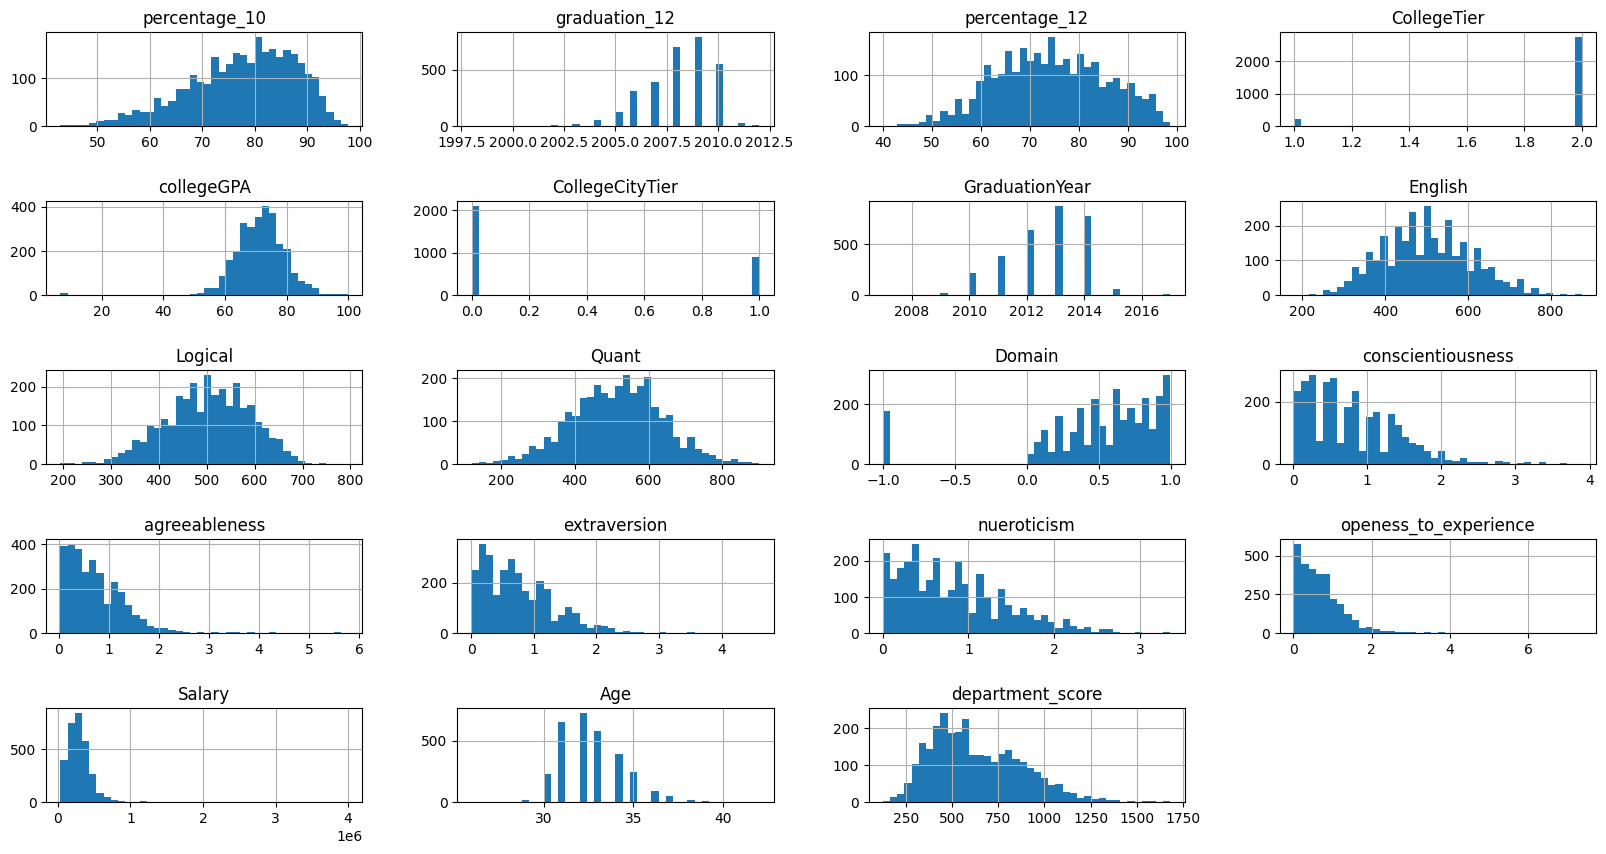

In [24]:
## Check Distr of Numerical Features

df.hist(bins=40, figsize=(20, 10))
plt.subplots_adjust(hspace=0.8)
plt.show()

In [25]:
## Get the Numerical cols firstly

df['Domain'].loc[df['Domain']==-1] = df['Domain'].median()

out_cols = ['percentage_10', 'percentage_12', 'collegeGPA', 'English', 'Logical', 'Quant','department_score','agreeableness',
            'department_score','Domain', 'conscientiousness', 'extraversion', 'nueroticism','openess_to_experience']
for col in out_cols:
    each_idx = detect_outliers(data=df, n=0, features=[col])
    each_median = df[col].median()

    df.loc[each_idx, col] = each_median

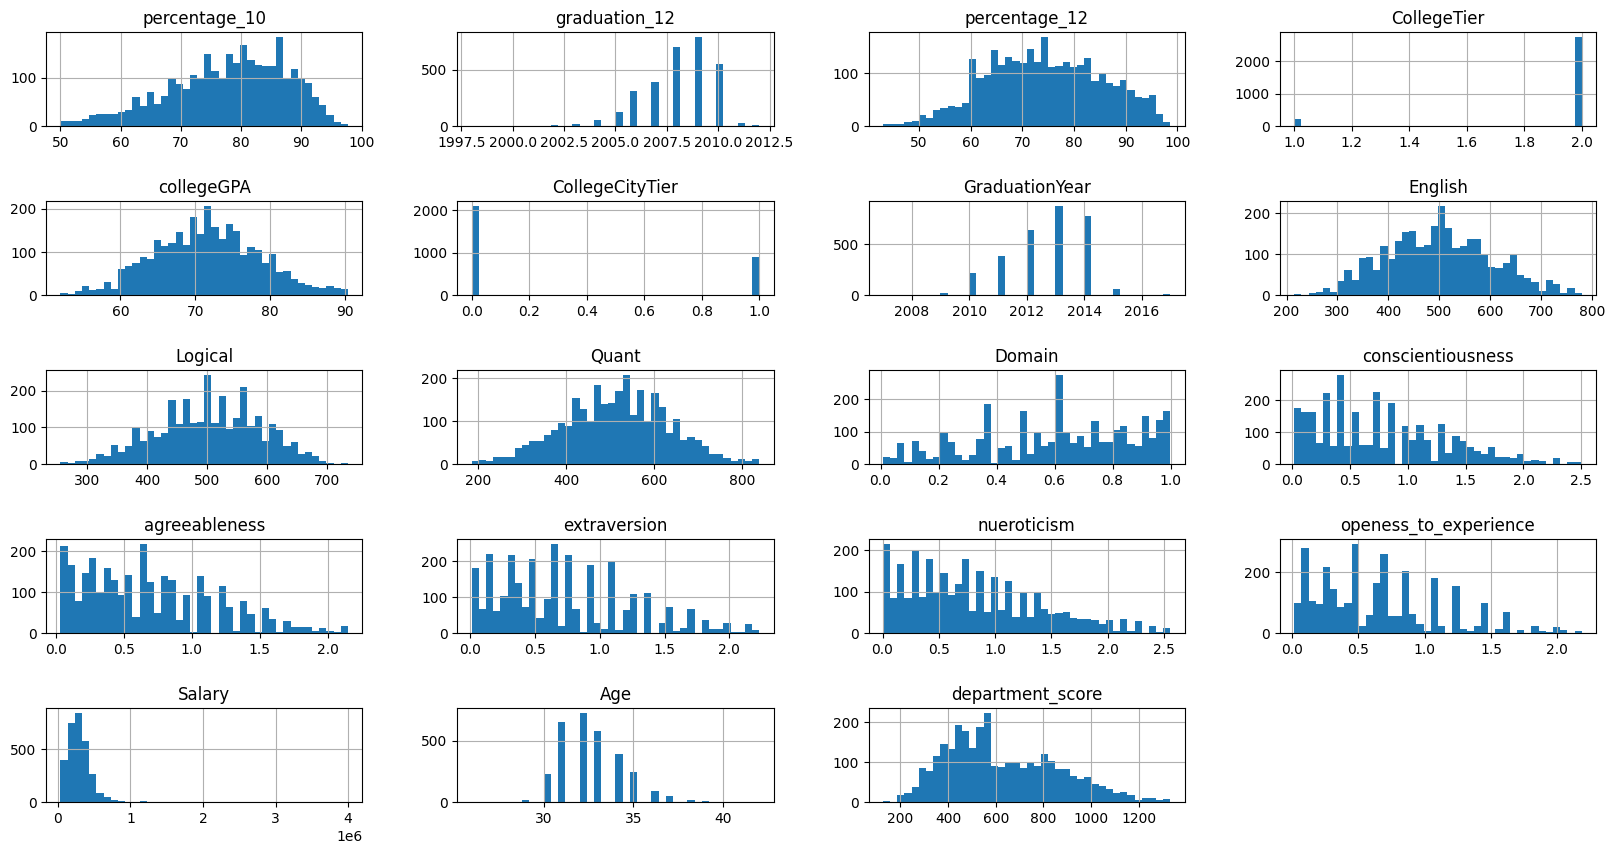

In [26]:
## Check Distr of Numerical Features
df.hist(bins=40, figsize=(20, 10))
plt.subplots_adjust(hspace=0.8)
plt.show()

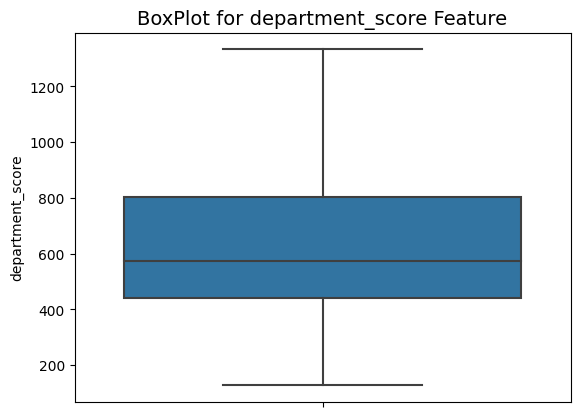

In [27]:
## some viz
sns.boxplot(data=df, y='department_score')
plt.title('BoxPlot for department_score Feature', fontsize=14, color='k')
plt.show()

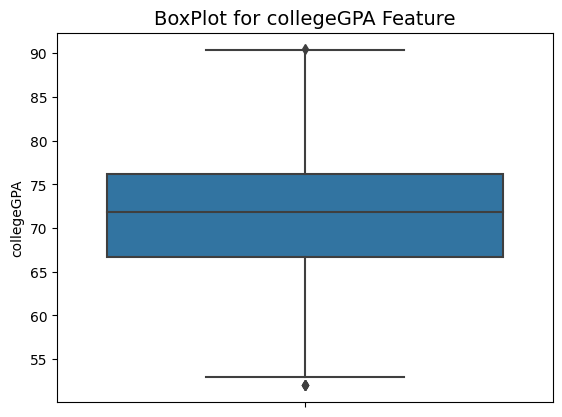

In [28]:
sns.boxplot(data=df, y='collegeGPA')
plt.title('BoxPlot for collegeGPA Feature', fontsize=14, color='k')
plt.show()

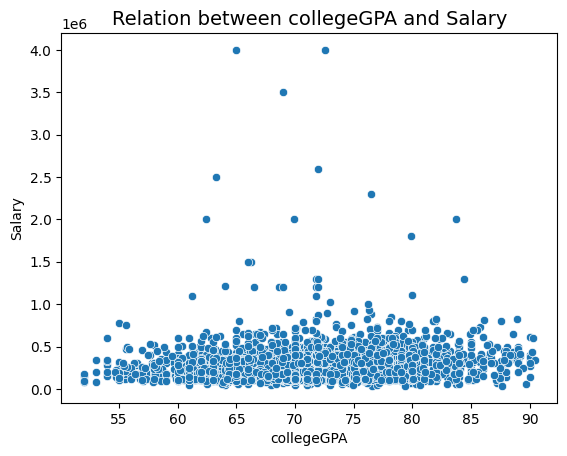

In [29]:
## Check collegeGPA and salary
sns.scatterplot(data=df, x='collegeGPA', y='Salary')
plt.title('Relation between collegeGPA and Salary', fontsize=14, color='k')
plt.show()

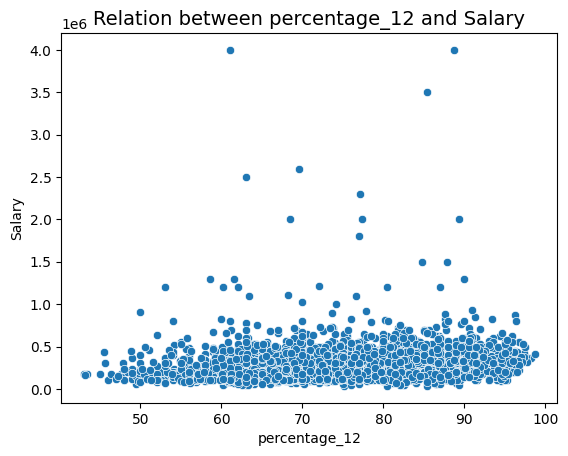

In [30]:
## Check percentage_12 and salary
sns.scatterplot(data=df, x='percentage_12', y='Salary')
plt.title('Relation between percentage_12 and Salary', fontsize=14, color='k')
plt.show()

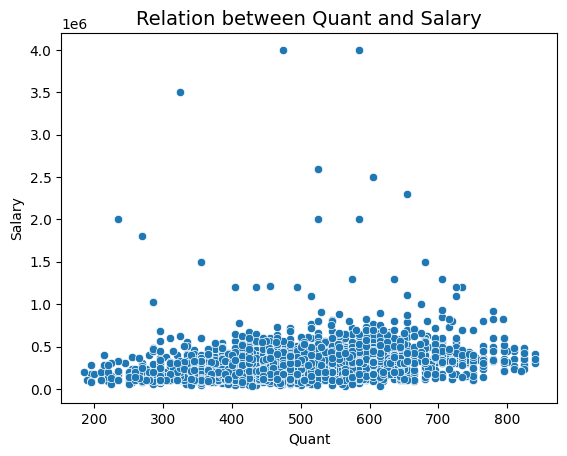

In [31]:
## Check Quant and salary
sns.scatterplot(data=df, x='Quant', y='Salary')
plt.title('Relation between Quant and Salary', fontsize=14, color='k')
plt.show()

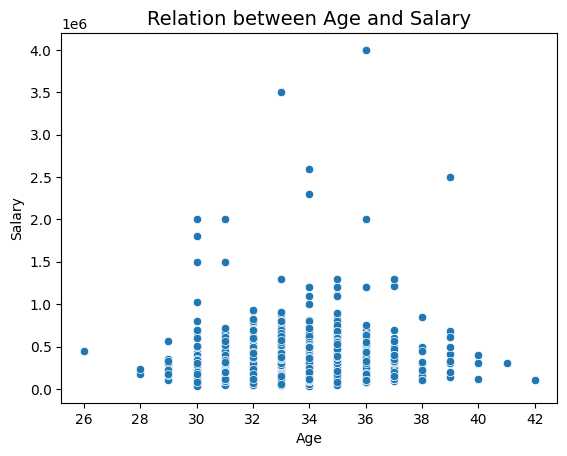

In [32]:
## Check Age and salary
sns.scatterplot(data=df, x='Age', y='Salary')
plt.title('Relation between Age and Salary', fontsize=14, color='k')
plt.show()

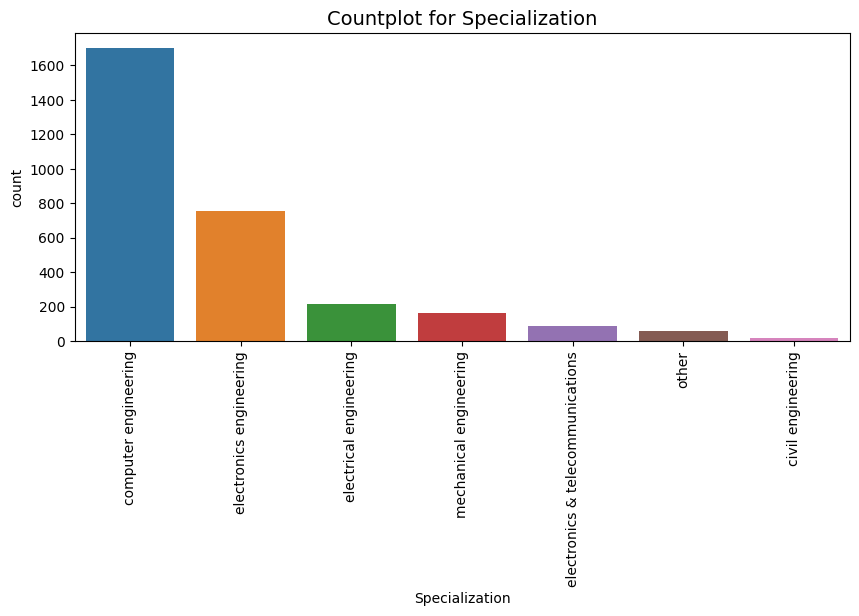

In [33]:
## Specialization Feature
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Specialization', order=df['Specialization'].value_counts().index.tolist())
plt.title('Countplot for Specialization', fontsize=14, color='k')
plt.xticks(rotation=90)
plt.show()

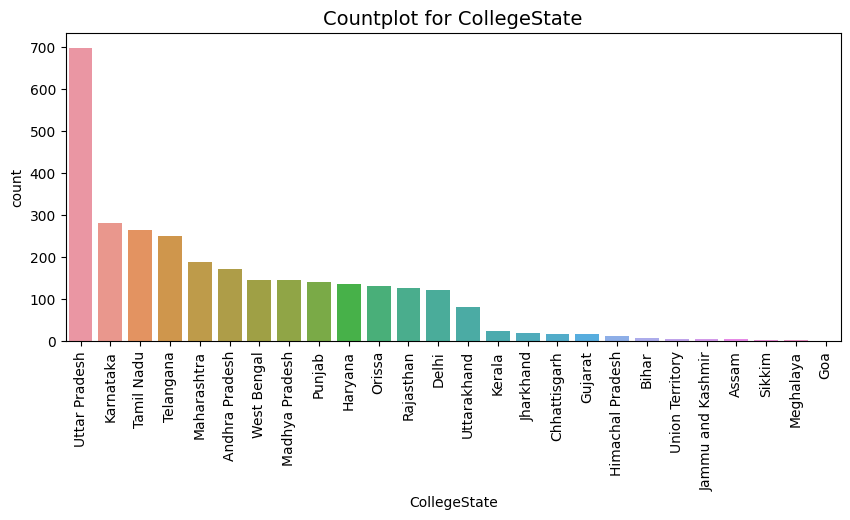

In [34]:
## CollegeState Feature
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='CollegeState', order=df['CollegeState'].value_counts().index.tolist())
plt.title('Countplot for CollegeState', fontsize=14, color='k')
plt.xticks(rotation=90)
plt.show()

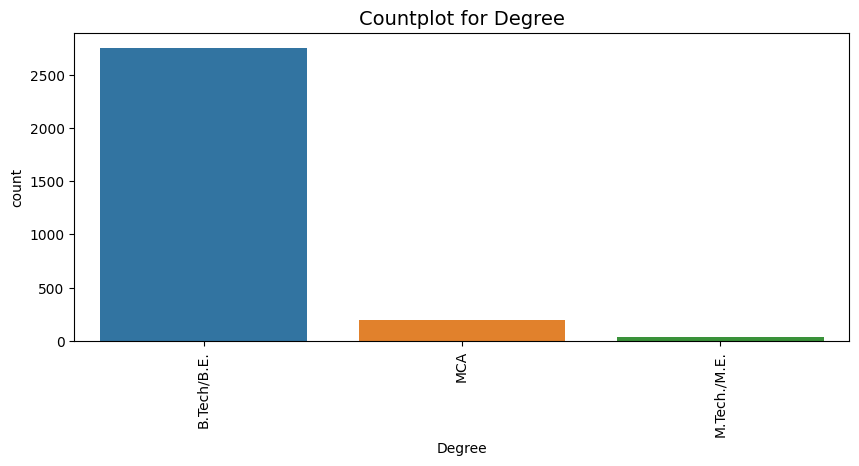

In [35]:
## Degree Feature
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Degree', order=df['Degree'].value_counts().index.tolist())
plt.title('Countplot for Degree', fontsize=14, color='k')
plt.xticks(rotation=90)
plt.show()

* `Bivariate Viz`

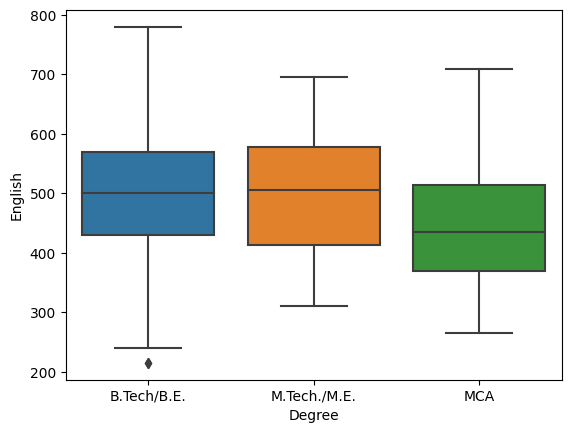

In [36]:
## Check boxplot (Degree) and (English)
sns.boxplot(data=df, y='English', x='Degree')
plt.show()

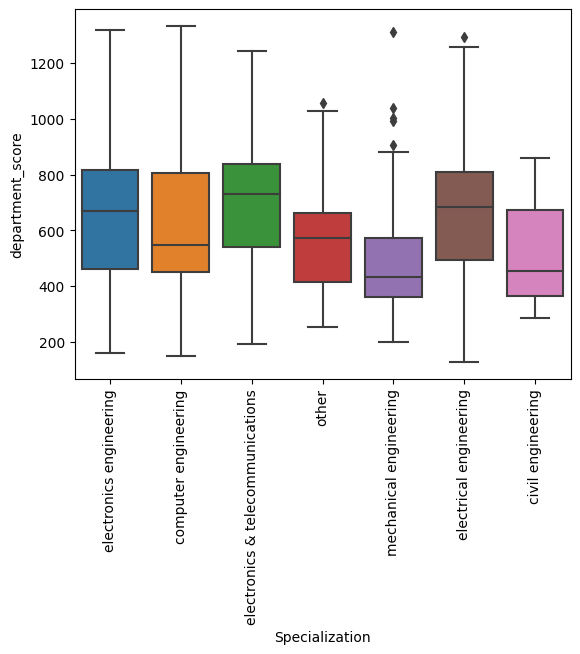

In [37]:
## Check boxplot (Specialization) and (English)
sns.boxplot(data=df, y='department_score', x='Specialization')
plt.xticks(rotation=90)
plt.show()

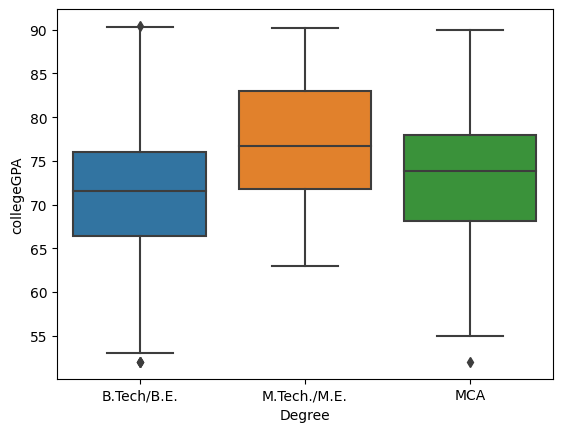

In [38]:
## Check boxplot (Degree) and (English)
sns.boxplot(data=df, y='collegeGPA', x='Degree')
plt.show()

* `Multivatiate Viz`

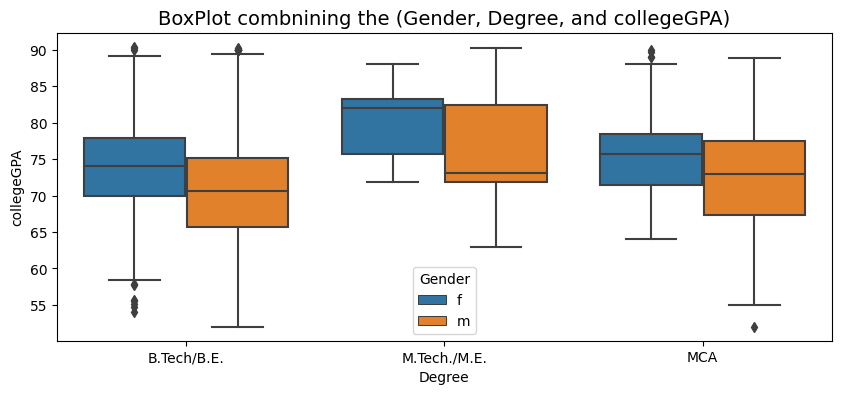

In [39]:
## check the (Gender) with (Degree) with (collegeGPA)
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, y='collegeGPA', x='Degree', hue='Gender')
plt.title('BoxPlot combnining the (Gender, Degree, and collegeGPA)', fontsize=14, color='k')
plt.show()

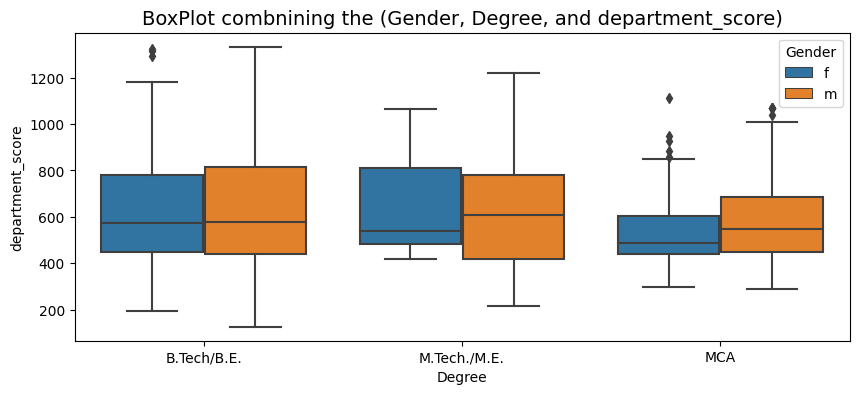

In [40]:
## check the (Gender) with (Degree) with (department_score)
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, y='department_score', x='Degree', hue='Gender')
plt.title('BoxPlot combnining the (Gender, Degree, and department_score)', fontsize=14, color='k')
plt.show()

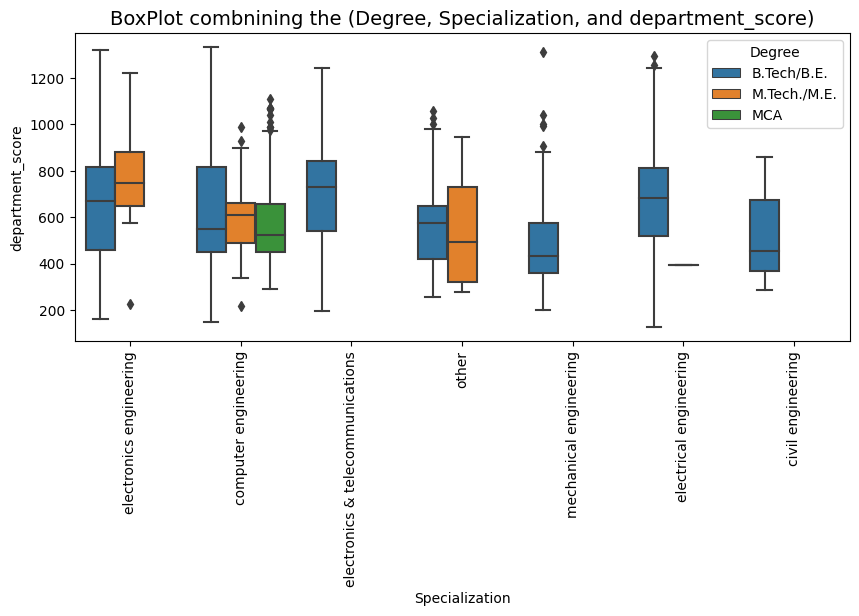

In [41]:
## check the (Degree) with (Specialization) with (department_score)
plt.figure(figsize=(10, 4))
sns.boxplot(data=df, y='department_score', x='Specialization', hue='Degree')
plt.title('BoxPlot combnining the (Degree, Specialization, and department_score)', fontsize=14, color='k')
plt.xticks(rotation=90)
plt.show()

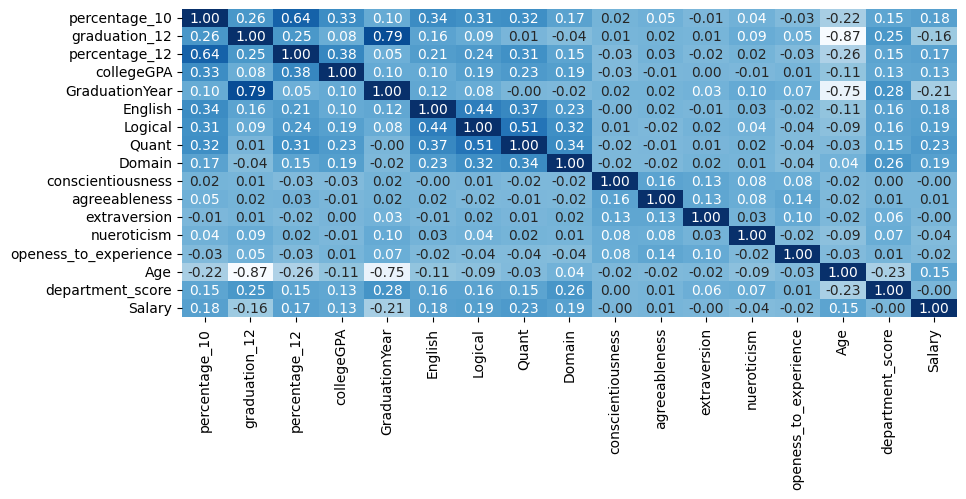

In [42]:
## Check correlation
plt.figure(figsize=(10, 4))
sns.heatmap(df[['percentage_10', 'graduation_12', 'percentage_12', 'collegeGPA', 'GraduationYear', 'English', 'Logical','Quant', 'Domain',
                'conscientiousness', 'agreeableness', 'extraversion', 'nueroticism', 'openess_to_experience',
                  'Age', 'department_score', 'Salary']].corr(), annot=True, cbar=False, cmap='Blues', fmt='.2f')
plt.show()

#### `Split dataset to (Train, Test, valid)`

In [43]:
df['CollegeTier'] = df['CollegeTier'].astype(str)
df['graduation_12'] = df['graduation_12'].astype(str)
df['GraduationYear'] = df['GraduationYear'].astype(str)

In [44]:
## to feature and target
X = df.drop(columns=['Salary'], axis=1)
y = df['Salary']


## split to train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=58)

## Check shapes
print('X_train.shape \t', X_train.shape)
print('y_train.shape \t', y_train.shape)
print('**'*20)
print('X_valid.shape \t', X_valid.shape)
print('y_valid.shape \t', y_valid.shape)


X_train.shape 	 (2247, 24)
y_train.shape 	 (2247,)
****************************************
X_valid.shape 	 (750, 24)
y_valid.shape 	 (750,)


In [45]:
# Log Transform for the target
def log_transform(x):
    return np.log1p(x)

# Log Transform
y_train_log = log_transform(y_train)
y_valid_log = log_transform(y_valid)

#### `Data Preprocessing`

In [46]:
#for numerical cols

num_cols = X_train.select_dtypes(include='number').columns.tolist()
num_cols

['percentage_10',
 'percentage_12',
 'collegeGPA',
 'CollegeCityTier',
 'English',
 'Logical',
 'Quant',
 'Domain',
 'conscientiousness',
 'agreeableness',
 'extraversion',
 'nueroticism',
 'openess_to_experience',
 'Age',
 'department_score']

In [47]:
cat_cols = X_train.select_dtypes(exclude='number').columns.tolist()


In [48]:

num_pipeline = Pipeline(steps= [('Impute Numerical', KNNImputer(n_neighbors=5)),
                                 ('Scaling', StandardScaler())])

cat_pipeline = Pipeline(steps= [('Impute Categorical', SimpleImputer(strategy='most_frequent')),
                                 ('BE', BinaryEncoder())])

preprocessing = ColumnTransformer(transformers=[('Numerical', num_pipeline, num_cols),
                                                 ('Categorical', cat_pipeline, cat_cols)],
                                   )

preprocessing

ColumnTransformer(transformers=[('Numerical',
                                 Pipeline(steps=[('Impute Numerical',
                                                  KNNImputer()),
                                                 ('Scaling',
                                                  StandardScaler())]),
                                 ['percentage_10', 'percentage_12',
                                  'collegeGPA', 'CollegeCityTier', 'English',
                                  'Logical', 'Quant', 'Domain',
                                  'conscientiousness', 'agreeableness',
                                  'extraversion', 'nueroticism',
                                  'openess_to_experience', 'Age',
                                  'department_score']),
                                ('Categorical',
                                 Pipeline(steps=[('Impute Categorical',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('BE', BinaryEncoder())]),
                                 ['Gender', 'board_10', 'graduation_12',
                                  'board_12', 'CollegeTier', 'Degree',
                                  'Specialization', 'CollegeState',
                                  'GraduationYear'])])

-----------

#### `Building Models`

`Regression Task`

* `1. Linear Regression`

In [49]:
final_pipeline = Pipeline(steps=[('Preprocessing', preprocessing), ('Model', LinearRegression())])


In [50]:


result = cross_validate(final_pipeline, X_train, y_train_log, cv = 5, return_train_score= True, scoring= 'r2')
result

{'fit_time': array([0.282547  , 0.20466542, 0.14639997, 0.17179465, 0.23424387]),
 'score_time': array([0.04687476, 0.03124881, 0.04687142, 0.03988743, 0.02706695]),
 'test_score': array([0.18284281, 0.25141842, 0.28217706, 0.2081984 , 0.2824844 ]),
 'train_score': array([0.29406596, 0.27552754, 0.26775861, 0.29017021, 0.27021927])}

In [51]:
final_pipeline.fit(X_train, y_train_log)

Pipeline(steps=[('Preprocessing',
                 ColumnTransformer(transformers=[('Numerical',
                                                  Pipeline(steps=[('Impute '
                                                                   'Numerical',
                                                                   KNNImputer()),
                                                                  ('Scaling',
                                                                   StandardScaler())]),
                                                  ['percentage_10',
                                                   'percentage_12',
                                                   'collegeGPA',
                                                   'CollegeCityTier', 'English',
                                                   'Logical', 'Quant', 'Domain',
                                                   'conscientiousness',
                                                   'agreeableness',
                                                   'extraversion',
                                                   'nueroticism',
                                                   'openess_to_experience',
                                                   'Age', 'department_score']),
                                                 ('Categorical',
                                                  Pipeline(steps=[('Impute '
                                                                   'Categorical',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('BE',
                                                                   BinaryEncoder())]),
                                                  ['Gender', 'board_10',
                                                   'graduation_12', 'board_12',
                                                   'CollegeTier', 'Degree',
                                                   'Specialization',
                                                   'CollegeState',
                                                   'GraduationYear'])])),
                ('Model', LinearRegression())])

`2. try all our models to select the best one of them`

In [52]:
models = []
models.append(("Linear Regression", LinearRegression()))
models.append(("Knn", KNeighborsRegressor()))
models.append(("Decision Tree", DecisionTreeRegressor()))
models.append(("Random Forest", RandomForestRegressor()))
models.append(("Ada boost", AdaBoostRegressor()))
models.append(("Xgb", XGBRegressor()))
models.append(("lightGBM", lightgbm.LGBMRegressor()))

for model in models:
    final_pipeline = Pipeline(steps=[('Preprocessing', preprocessing), ('Model', model[1])])
    result = cross_validate(final_pipeline, X_train, y_train_log, cv = 5, return_train_score= True, scoring= 'r2')
    print(model[0])
    print('Train R2 score : ', (result['train_score'].mean()) * 100)
    print('Test R2 score : ', (result['test_score'].mean()) * 100)
    print('\n')

Linear Regression
Train R2 score :  27.95483165749425
Test R2 score :  24.142421752449916


Knn
Train R2 score :  39.442629934340346
Test R2 score :  9.273649093928087


Decision Tree
Train R2 score :  100.0
Test R2 score :  -65.85058325919245


Random Forest
Train R2 score :  88.87014208916801
Test R2 score :  21.606040414744356


Ada boost
Train R2 score :  26.14696856149754
Test R2 score :  11.351486943348332


Xgb
Train R2 score :  99.1558692457587
Test R2 score :  9.890551388765804


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1875
[LightGBM] [Info] Number of data points in the train set: 1797, number of used features: 46
[LightGBM] [Info] Start training from score 12.468574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000814 secon

`choose LinearRegression model`

In [53]:
final_pipeline = Pipeline(steps=[('Preprocessing', preprocessing), ('Model', LinearRegression())])
result = cross_validate(final_pipeline, X_train, y_train_log, cv = 5, return_train_score= True, scoring= 'r2')
result

{'fit_time': array([0.21071243, 0.17533445, 0.17097664, 0.19023013, 0.20861459]),
 'score_time': array([0.0312655 , 0.03523421, 0.03831577, 0.05160999, 0.04699206]),
 'test_score': array([0.18284281, 0.25141842, 0.28217706, 0.2081984 , 0.2824844 ]),
 'train_score': array([0.29406596, 0.27552754, 0.26775861, 0.29017021, 0.27021927])}

In [54]:
params={
    'verbose':[True,False],
   

}

In [55]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(param_grid= params, estimator= final_pipeline, cv = 5, return_train_score= True, scoring= 'r2', n_jobs= -1)

In [56]:
grid_search.fit(X_train, y_train_log)

[Pipeline] ..... (step 1 of 2) Processing Preprocessing, total=   0.2s
[Pipeline] ............. (step 2 of 2) Processing Model, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessing',
                                        ColumnTransformer(transformers=[('Numerical',
                                                                         Pipeline(steps=[('Impute '
                                                                                          'Numerical',
                                                                                          KNNImputer()),
                                                                                         ('Scaling',
                                                                                          StandardScaler())]),
                                                                         ['percentage_10',
                                                                          'percentage_12',
                                                                          'collegeGPA',
                                                                          'CollegeCityTier',
                                                                          'English',
                                                                          'Logical',
                                                                          'Quant',
                                                                          'Domain',
                                                                          'conscientiousness',
                                                                          'agreeableness',
                                                                          'extraversion',
                                                                          'nuerotici...
                                                                        ('Categorical',
                                                                         Pipeline(steps=[('Impute '
                                                                                          'Categorical',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('BE',
                                                                                          BinaryEncoder())]),
                                                                         ['Gender',
                                                                          'board_10',
                                                                          'graduation_12',
                                                                          'board_12',
                                                                          'CollegeTier',
                                                                          'Degree',
                                                                          'Specialization',
                                                                          'CollegeState',
                                                                          'GraduationYear'])])),
                                       ('Model', LinearRegression())]),
             n_jobs=-1, param_grid={'verbose': [True, False]},
             return_train_score=True, scoring='r2')

In [57]:
joblib.dump(grid_search, 'linear_reg.pkl')
# inputs = joblib.dump(X.columns, 'inputs.pkl')

['linear_reg.pkl']

In [58]:
X.columns

Index(['Gender', 'percentage_10', 'board_10', 'graduation_12', 'percentage_12',
       'board_12', 'CollegeTier', 'Degree', 'Specialization', 'collegeGPA',
       'CollegeCityTier', 'CollegeState', 'GraduationYear', 'English',
       'Logical', 'Quant', 'Domain', 'conscientiousness', 'agreeableness',
       'extraversion', 'nueroticism', 'openess_to_experience', 'Age',
       'department_score'],
      dtype='object')

In [59]:
X_train.shape

(2247, 24)

In [60]:
y_train.shape

(2247,)